## Análisis Exploratorio de Datos:

En este notebook se realiza un análisis de los datos contenidos en los dataframes de usuarios, reviews y juegos de Steam, a los fines de armar un sistema de recomendación de tipo filtro colaborativo a partir de descomposición UV.

In [2]:
# En primer lugar, se importan las librerías con las que vamos a trabajar:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import warnings
warnings.filterwarnings('ignore')
sns.set()

In [3]:
# Se cargan los archivos con los que se trabajará:
df_games = pd.read_parquet('steam_games.parquet')
df_reviews = pd.read_parquet('user_reviews.parquet')
df_items = pd.read_parquet('user_items_extended.parquet')

In [29]:
# Se combina el df de user_reviews con el de juegos:
df_rev_games = pd.merge(df_reviews,df_games, on = "item_id", how="inner")

# Se combina el df de user_items con el de juegos:
df_items_games = pd.merge(df_items,df_games, on = "item_id", how="inner")

En primer lugar, se observa la cantidad de juegos distintos que incluye el Data Frame:

In [ ]:
# Chequeamos la cantidad de valores únicos en la columna "item_id":
print('Cantidad de juegos:', df_games["item_id"].nunique())

Cantidad de juegos: 22527


Luego observamos la cantidad de usuarios:

In [ ]:
# Chequeamos la cantidad de valores únicos en la columna "user_id":
print('Cantidad de usuarios:', df_items["user_id"].nunique())

Cantidad de usuarios: 70912


In [5]:
df_games.columns

Index(['app_name', 'title', 'price', 'item_id', 'developer', 'release_year',
       'Action', 'Adventure', 'Animation and Modeling', 'Audio Production',
       'Casual', 'Design and llustration', 'Early Access', 'Education',
       'Free to Play', 'Indie', 'Massively Multiplayer', 'Photo Editing',
       'RPG', 'Racing', 'Simulation', 'Software Training', 'Sports',
       'Strategy', 'Utilities', 'Video Production', 'Web Publishing'],
      dtype='object')

Consultamos la cantidad de juegos lanzados por año:

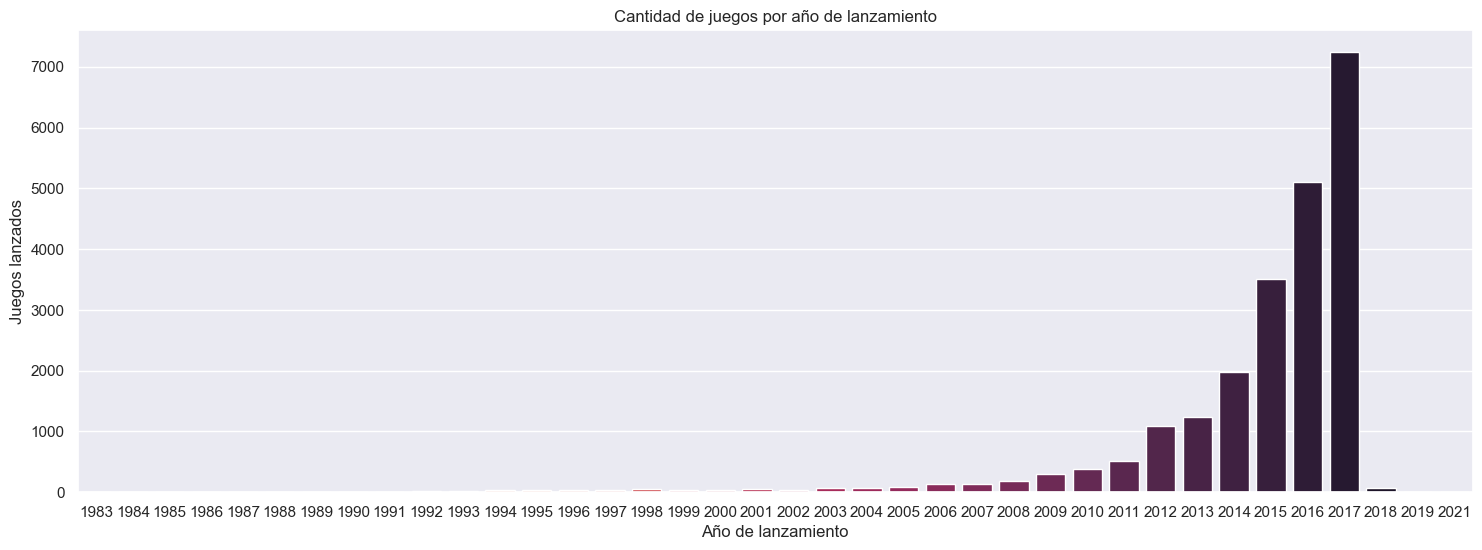

In [14]:
# Visualizamos
plt.figure(figsize=(18,6))
sns.countplot(data = df_games, x = "release_year", palette= "rocket_r")
plt.xticks(rotation=0)
plt.ylabel('Juegos lanzados')
plt.xlabel('Año de lanzamiento')
plt.title('Cantidad de juegos por año de lanzamiento')
plt.show()

Luego cuál es el **top 10** de juegos en cantidad de usuarios:

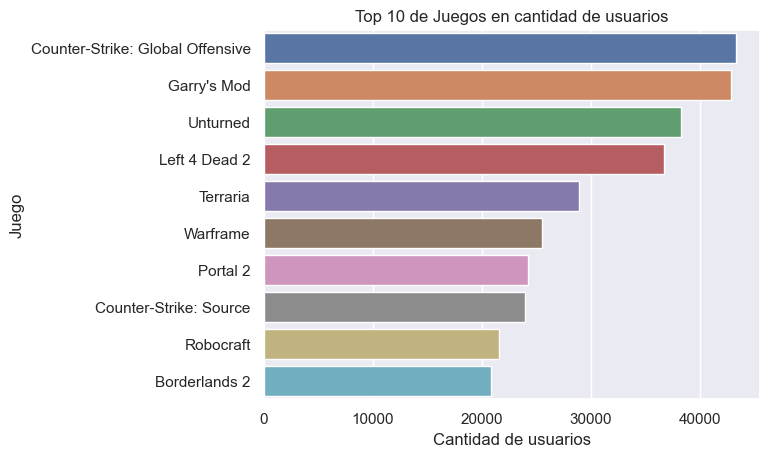

In [15]:
# Se calcula el top 10 de juegos con mayor cantidad de usuarios:
top_games_users = df_items_games.groupby("app_name")["user_id"].count().sort_values(ascending=False).head(10).reset_index()

# Visualizamos
sns.barplot(data = top_games_users, y = "app_name", x = "user_id")
plt.xticks(rotation=0)
plt.ylabel('Juego')
plt.xlabel('Cantidad de usuarios')
plt.title('Top 10 de Juegos en cantidad de usuarios')
plt.show()

Se calcula el **top 10** de **juegos** con **análisis de sentimiento positivo**:

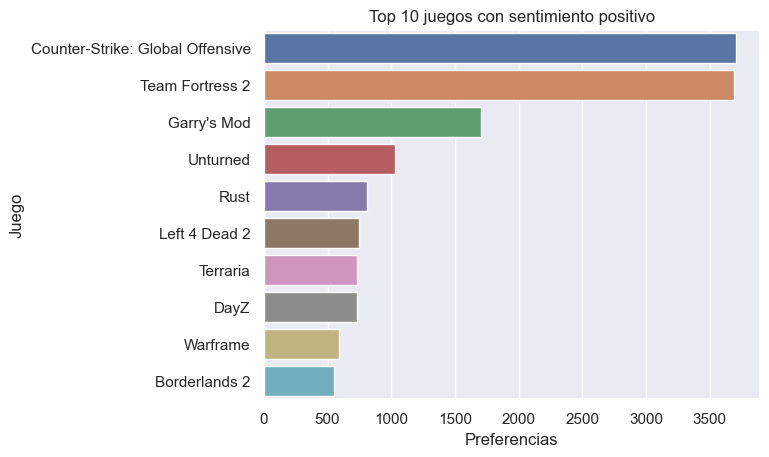

In [ ]:
# Se calcula el top 10 de juegos con análisis de sentimiento positivo:
positive_reviews = df_rev_games[df_rev_games["sentiment_analysis"] == 2]
# Se agrupan por nombre de juego y se seleccionan los 10 con mas recomendaciones:
positive_reviews = df_rev_games.groupby("app_name")["sentiment_analysis"].count().sort_values(ascending=False).head(10).reset_index()

# Visualizamos
sns.barplot(data= positive_reviews, y = "app_name", x = "sentiment_analysis")
plt.xticks(rotation=0)
plt.ylabel('Juego')
plt.xlabel('Preferencias')
plt.title('Top 10 juegos con sentimiento positivo')
plt.show()

Se calcula el top 10 de juegos recomendados:

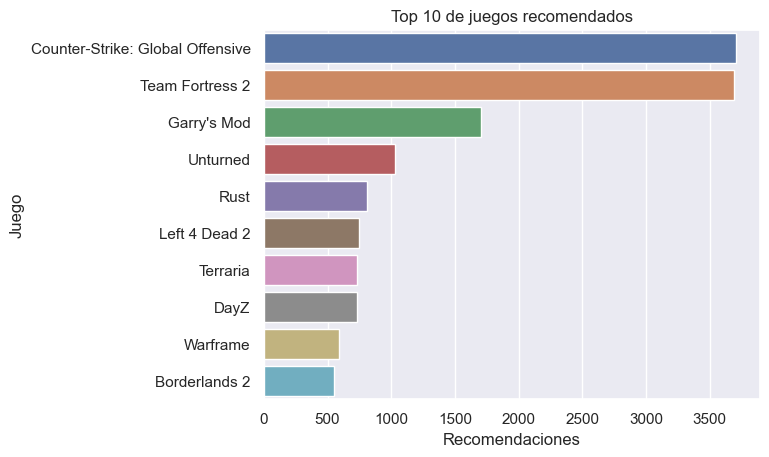

In [ ]:
# Se filtran las recomendaciones de usuarios:
recommended_games = df_rev_games[df_rev_games["recommend"] == 1]
# Se agrupan por nombre de juego y se seleccionan los 10 con mas recomendaciones:
recommended_games = df_rev_games.groupby("app_name")["recommend"].count().sort_values(ascending=False).head(10).reset_index()

# Visualizamos
sns.barplot(data= recommended_games, y = "app_name", x = "recommend")
plt.xticks(rotation=0)
plt.ylabel('Juego')
plt.xlabel('Recomendaciones')
plt.title('Top 10 de juegos recomendados')
plt.show()

Por otro lado, se calcula el **top 10** de juegos con más **horas jugadas en promedio**:

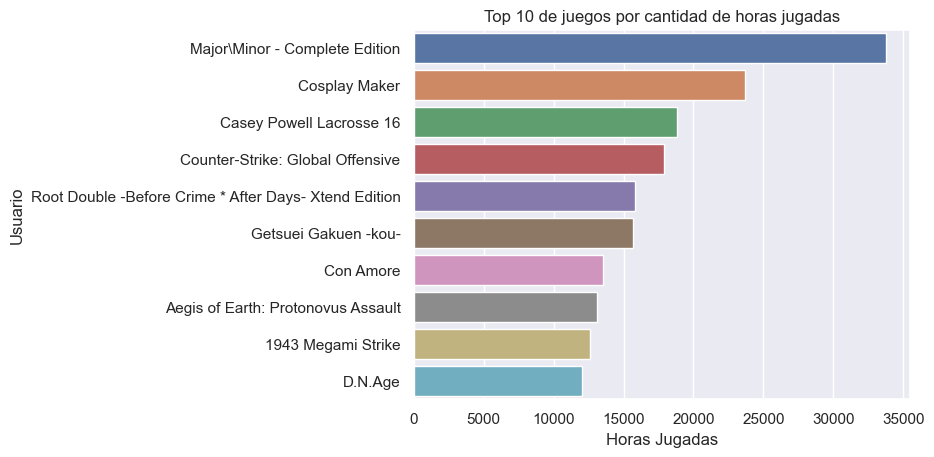

In [64]:
# Se agrupan por juego y se seleccionan los 10 con mas horas jugadas:
top_games_hours = df_items_games.groupby("app_name")["playtime_forever"].mean().sort_values(ascending=False).head(10).reset_index()

# Visualizamos
sns.barplot(data = top_games_hours, y = "app_name", x = "playtime_forever")
plt.ylabel('Juego')
plt.xlabel('Horas promedio Jugadas')
plt.title('Top 10 de juegos por cantidad de horas jugadas')
plt.show()

Comparamos fecha de lanzamiento:

In [68]:
# N° 1 del ranking
df_items_games[df_items_games["app_name"] == "Major\Minor - Complete Edition"]["release_year"].iloc[0]

2016

In [69]:
# N° 4 del ranking
df_items_games[df_items_games["app_name"] == "Counter-Strike: Global Offensive"]["release_year"].iloc[0]

2012

De acuerdo a lo expuesto anteriormente, podemos concluir que el juego **"Counter-Strike: Global Offensive"** es el juego con mayor cantidad de usuarios (más de la mitad del total), recomendaciones y reviews con expresión de sentimiento positivo. Cabe destacar que el nivel de reviews es muy bajo en comparación a la cantidad de usuarios del juego, representando para este caso en particular, menos del 10%.

No obstante, cabe destacar que el juego **"Major\Minor - Complete Edition"** es más nuevo, pero acumula mayor cantidad de horas jugadas en promedio.

Luego chequeamos la cantidad de reviews por "análisis de sentimiento":

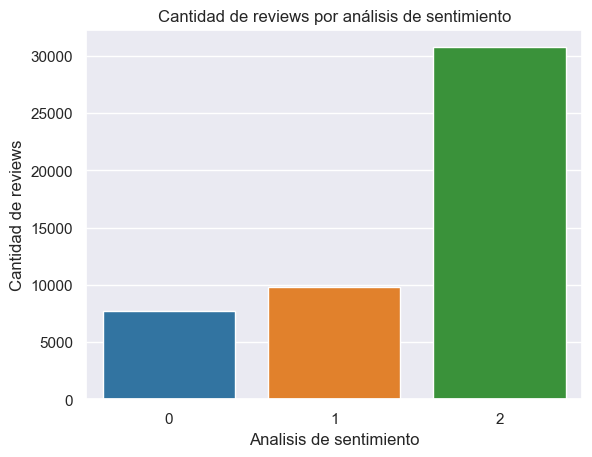

In [70]:
# Visualizamos
sns.countplot(data= df_reviews, x = "sentiment_analysis", palette= "tab10")
plt.xticks(rotation=0)
plt.ylabel('Cantidad de reviews')
plt.xlabel('Analisis de sentimiento')
plt.title('Cantidad de reviews por análisis de sentimiento')
plt.show()

Observamos que de las reviews realizadas, la mayoría fueron realizadas expresando un **sentimiento positivo** hacia el juego.

## Debido a que el sistema de recomendación que vamos a construir es de tipo de filtro colaborativo, se considera que sería mejor crear una nueva variable que contemple tanto la expresión de sentimiento positivo hacia el juego como la recomendación o no por el usuario del mismo, por lo que a continuación se crea la variable **user_choice**, que represeta la **preferencia** del usuario por el juego:

In [ ]:
# Se crea la columna "user_choice":
df_rev_games["user_choice"] = np.where((df_rev_games['sentiment_analysis'] == 2) & (df_rev_games['recommend'] == 1), 1, 0)
df_rev_games.head()

,user_id,item_id,recommend,posted_year,sentiment_analysis,app_name,title,price,developer,release_year,...,RPG,Racing,Simulation,Software Training,Sports,Strategy,Utilities,Video Production,Web Publishing,user_choice
0,76561197970982479,1250,1,2011,2,Killing Floor,Killing Floor,19.99,Tripwire Interactive,2009,...,0,0,0,0,0,0,0,0,0,1
1,death-hunter,1250,1,2015,2,Killing Floor,Killing Floor,19.99,Tripwire Interactive,2009,...,0,0,0,0,0,0,0,0,0,1
2,DJKamBer,1250,1,2013,0,Killing Floor,Killing Floor,19.99,Tripwire Interactive,2009,...,0,0,0,0,0,0,0,0,0,0
3,diego9031,1250,1,2015,1,Killing Floor,Killing Floor,19.99,Tripwire Interactive,2009,...,0,0,0,0,0,0,0,0,0,0
4,76561198081962345,1250,1,2014,1,Killing Floor,Killing Floor,19.99,Tripwire Interactive,2009,...,0,0,0,0,0,0,0,0,0,0


## A continuación, visualizamos el **top 10 de juegos preferidos** por usuarios:

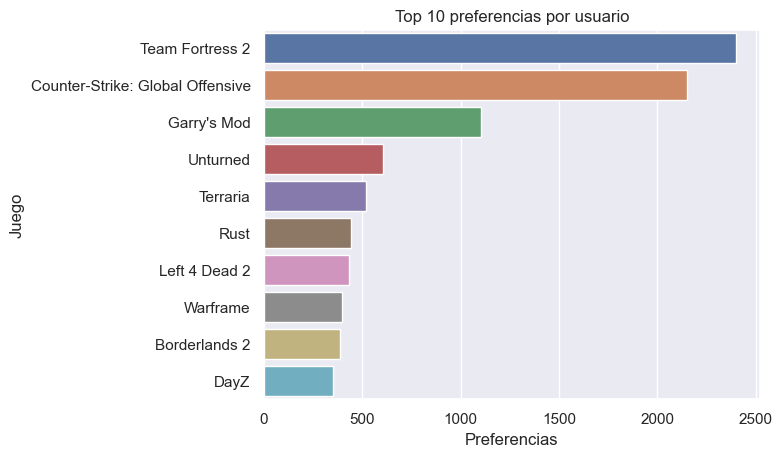

In [72]:
'''
# Se calcula el top 10 de juegos preferidos por los usuarios:
user_recomm = df_rev_games.groupby("app_name")["user_choice"].sum().sort_values(ascending=False).head(10).reset_index()

# Visualizamos
sns.barplot(data = user_recomm, y = "app_name", x = "user_choice")
plt.xticks(rotation=0)
plt.ylabel('Juego')
plt.xlabel('Preferencias')
plt.title('Top 10 preferencias por usuario')
plt.show()
'''

## Al crear una nueva variable, podemos observar que el **juego preferido** por los usuarios que hicieron reviews fue el **Team Fortress 2**.

Por otro lado, analizamos el **top 10** de **usuarios** en **cantidad de reviews**:

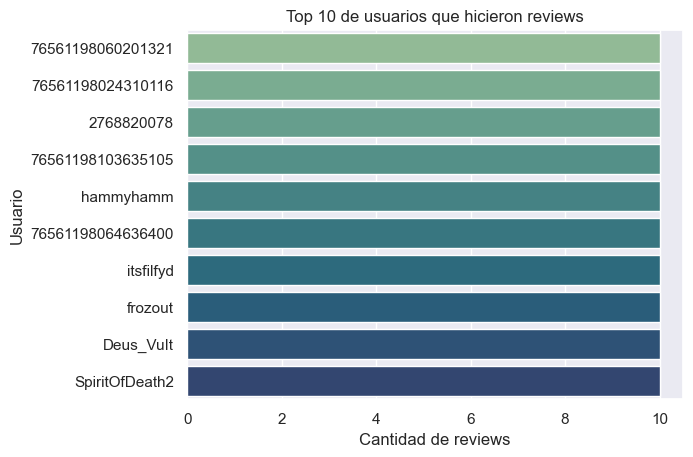

In [91]:
top_user_reviews = df_rev_games.groupby("user_id")["recommend"].count().sort_values(ascending=False).head(10).reset_index()

# Visualizamos
sns.barplot(data = top_user_reviews, y = "user_id", x = "recommend",palette="crest")
plt.xticks(rotation=0)
plt.xlabel('Cantidad de reviews')
plt.ylabel('Usuario')
plt.title('Top 10 de usuarios que hicieron reviews')
plt.show()

Como podemos ver, la cantidad máxima de reviews por usuario es de 10, por lo que se chequea los últimos 10 en caso de que exista la misma cantidad de reviews para todos los usuarios:

In [78]:
# Se analizan los últimos 10
df_rev_games.groupby("user_id")["recommend"].count().sort_values(ascending=False).tail(10)

user_id
MasterMindz          1
Masterhour           1
76561198070736657    1
76561198070735417    1
MatLyGames           1
MateusBeta           1
Matoota              1
76561198070728917    1
76561198070714959    1
--000--              1
Name: recommend, dtype: int64

Como podemos ver, hay usuarios que sólo han hecho una recomendación.

A continuación observamos el top 10 de usuarios con más horas jugadas:

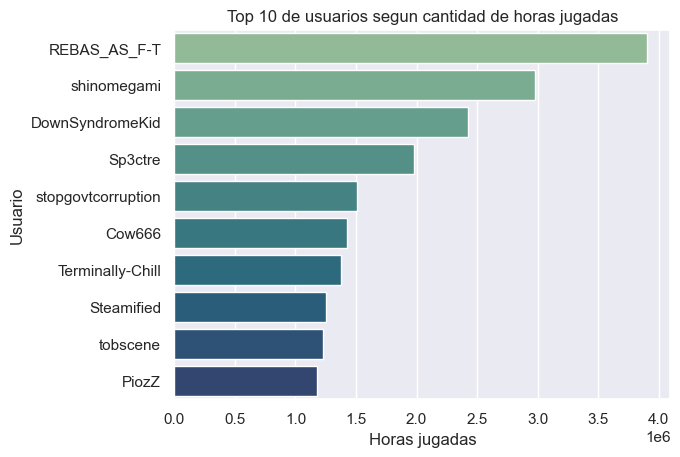

In [92]:
# Se agrupan la informacion por usuario y se suman las horas jugadas
top_user_hours = df_items_games.groupby("user_id")["playtime_forever"].sum().sort_values(ascending=False).head(10).reset_index()

# Visualizamos
sns.barplot(data = top_user_hours, x = "playtime_forever", y = "user_id", palette="crest")
plt.xlabel('Horas jugadas')
plt.ylabel('Usuario')
plt.title('Top 10 de usuarios segun cantidad de horas jugadas')
plt.show()

# Modelo de Machine Learning - Sistema de Recomendación:

A continuación se entrenará un modelo de Sistema de Recomendación de filtro colaborativo mediante el uso de la librería Surprise, por lo que en primer lugar importamos la librerías necesarias para trabajar:

In [16]:
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split
from surprise import SVD

De acuerdo a lo consultado con la documentación del modelo, el mismo recibe como parámetros las siguientes variables:
    
    - Usuario
    - Rating
    - Item

In [17]:
# Filtramos las variables en el dataframe
df_RS = df_reviews[['user_id', 'item_id', 'sentiment_analysis']]
df_RS.shape

(48339, 3)

In [18]:
# Se instancia la clase "Reader()" de Surprise:
reader = Reader()

# Se carga la data en la clase respectiva:
data = Dataset.load_from_df(df_RS, reader)

# Se separan los datos en los grupos de entrenamiento y prueba:
trainset, testset = train_test_split(data, test_size = 0.20)

# Instanciamos el modelo:
model = SVD()

# Entrenamos:
model.fit(trainset)

# Se predice sobre el grupo de prueba
predictions = model.test(testset)

Medimos el desempeño del modelo a través del RMSE:

In [19]:
from surprise import accuracy

accuracy.rmse(predictions)

RMSE: 0.7566


0.7566421032374236

## Endpoint API:

A continuación se crea la función que permitirá obtener, a partir de un id de usuario, una lista con 5 recomendaciones de juegos para el mismo:

In [54]:
def user_recommendations(user_id):
    '''
    Devuelve una lista con 5 recomendaciones de juegos para el usuario ingresado.
  
    Ejemplo de retorno: 
    '''
    user = user_id
    # En primer lugar, sacamos los juegos que el usuario ya ha jugado:
    games_played = df_rev_games[df_rev_games['user_id'] == user]

    # Se eliminan del df de juegos los jugados por el usuario
    df_user = df_games[["item_id", "app_name"]].drop(games_played.item_id, errors='ignore')

    # Realizamos las predicciones y las agregamos en una nueva columna:
    df_user['estimate_Score'] = df_user['item_id'].apply(lambda x: model.predict(user, x).est)

    # Ordenamos el df de manera descendente en funcion al score y seleccionamos los 5 principales:
    recommendations = df_user.sort_values('estimate_Score', ascending=False)["app_name"].head(5).to_list()

    # Se crea la llave del diccionario de retorno
    llave_dic = f'Recomendaciones para el usuario {user}'
    
    # Se devuelven los resultados en un diccionario
    return {llave_dic : recommendations}

In [55]:
user = "76561197970982479"
# En primer lugar, sacamos los juegos que el usuario ya ha jugado:
games_played = df_rev_games[df_rev_games['user_id'] == user]

# Se eliminan del df de juegos los jugados por el usuario
df_user = df_games[["item_id", "app_name"]].drop(games_played.item_id, errors='ignore')

# Realizamos las predicciones y las agregamos en una nueva columna:
df_user['estimate_Score'] = df_user['item_id'].apply(lambda x: model.predict(user, x).est)

# Ordenamos el df de manera descendente en funcion al score y seleccionamos los 5 principales:
recommendations = df_user.sort_values('estimate_Score', ascending=False)["app_name"].head(5).to_list()

# Se crea la llave del diccionario de retorno
llave_dic = f'Recomendaciones para el usuario {user}'

# Se devuelven los resultados en un diccionario
resultado = {llave_dic : recommendations}
resultado

{'Recomendaciones para el usuario 76561197970982479': ['Europa Universalis IV',
  "Melody's Escape",
  'Ratz Instagib',
  'Doom 3: BFG Edition',
  'Metro: Last Light Redux']}

In [44]:
df_games.shape

(22527, 27)

In [27]:
# Se agrega al dataframe el nombre de los juegos y una columna que contiene:
#df_RS['Estimate_Score'] = df_RS['item_id'].apply(lambda x: model.test(df_RS["user_id"], x).est)
#recomendaciones_usuario['Estimate_Score'] = recomendaciones_usuario['Movie_Id'].apply(lambda x: model.predict(usuario, x).est)
#df_RS['app_name'] = pd.merge(df_RS, df_games, on = "item_id")["app_name"]

df_RS.head()

TypeError: predict() missing 1 required positional argument: 'iid'

In [10]:
predictions[1]

Prediction(uid='JonHT', iid=2, r_ui=222880.0, est=5, details={'was_impossible': False})